## Compute the azimuth and elevation phase maps

1. Compute the fft of each stimulation
2. To correct for phase delays subtract the phase of stimuli moving in opposite directions
3. Plot stimuli phase as time.

In [1]:
from wfield import *
import pandas as pd
from tifffile import imwrite
from scipy.ndimage import gaussian_filter,median_filter

%matplotlib inline


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import cupy as cp
cp._default_memory_pool.free_all_blocks()

In [3]:
### 路径和刺激重复次数。（本代码对应的是每个方向连续重复10次再下一个方向）
path_wfield = r'/home/lzx/data/WF_VC_liuzhaoxi/24.05.20_H78/retinotopy/process/20240520-194029-wfield'
nrepeats = 10
post_trial = 3   # 刺激消失后多取几秒

path_out = pjoin(path_wfield, '..', os.path.basename(path_wfield)[:16]+'retinotopy')
os.makedirs(path_out, exist_ok=True)


In [4]:
def reconstruct(u,svt,dims = None):
    if dims is None:
        dims = u.shape[:2]
    return u.dot(svt).reshape((*dims,-1)).transpose(-1,0,1).squeeze()

In [5]:
### load data
trials = pd.read_csv(pjoin(path_wfield, "trials.csv"), header=None, dtype=int).values
nframes_el = min(trials[:20, 3]) + post_trial*10
nframes_az = min(trials[20:40, 3]) + post_trial*10
# nframes_el = 130
# nframes_az = 163
U = cp.load(pjoin(path_wfield, 'U.npy'))
SVTcorr = cp.load(pjoin(path_wfield, 'SVTcorr.npy'))
nSVD = SVTcorr.shape[0]


### extract trial-data for 4 direction stimuli respectively.
def _sort_frames(nframes, *ntrials):
    avg = cp.empty((nSVD, 0, nframes))
    raw = cp.empty((nSVD, 0))
    for i in ntrials:
        avg = cp.concatenate((avg, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes].reshape(nSVD, 1, nframes)), axis=1)
        raw = cp.concatenate((raw, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes]), axis=1)
    avg = cp.mean(avg, axis=1)
    return avg, raw

avg_up, raw_up = _sort_frames(nframes_el, *range(nrepeats * 0, nrepeats * 1))
avg_down, raw_down = _sort_frames(nframes_el, *range(nrepeats * 1, nrepeats * 2))
avg_left, raw_left = _sort_frames(nframes_az, *range(nrepeats * 2, nrepeats * 3))
avg_right, raw_right = _sort_frames(nframes_az, *range(nrepeats * 3, nrepeats * 4))
cp._default_memory_pool.free_all_blocks()

In [6]:
# ### export trial-average tif

# imwrite(pjoin(path_out, 'avg_up.tif'), reconstruct(U, avg_up).astype('float32'), imagej=True)
# imwrite(pjoin(path_out, 'avg_down.tif'), reconstruct(U, avg_down).astype('float32'), imagej=True)
# imwrite(pjoin(path_out, 'avg_left.tif'), reconstruct(U, avg_left).astype('float32'), imagej=True)
# imwrite(pjoin(path_out, 'avg_right.tif'), reconstruct(U, avg_right).astype('float32'), imagej=True)
# print('Finish exporting trial-average tif')


In [7]:
### export rep tif

# imwrite(pjoin(path_out, 'rep_up.tif'), cp.asnumpy(reconstruct(U, raw_up)).astype('float32'), imagej=True)
# print('Finish exporting rep_up tif')
# imwrite(pjoin(path_out, 'rep_down.tif'), cp.asnumpy(reconstruct(U, raw_down)).astype('float32'), imagej=True)
# print('Finish exporting rep_down tif')
# imwrite(pjoin(path_out, 'rep_left.tif'), cp.asnumpy(reconstruct(U, raw_left)).astype('float32'), imagej=True)
# print('Finish exporting rep_left tif')
# imwrite(pjoin(path_out, 'rep_right.tif'), cp.asnumpy(reconstruct(U, raw_right)).astype('float32'), imagej=True)
# print('Finish exporting rep_right tif')
# cp._default_memory_pool.free_all_blocks()

In [8]:
### computes fft in SVD space

# from scipy.ndimage import gaussian_filter,median_filter
# mov = runpar(median_filter, U.transpose((2, 0, 1)), size=5)
# U1 = np.stack(mov).transpose((1, 2, 0)).astype(np.float32)
up = reconstruct(U, fft(raw_up.T, axis=0)[nrepeats])
down = reconstruct(U, fft(raw_down.T, axis=0)[nrepeats])
left = reconstruct(U, fft(raw_left.T, axis=0)[nrepeats])
right = reconstruct(U, fft(raw_right.T, axis=0)[nrepeats])
# phase_el = -1. * (np.angle(up) - np.angle(down)) % (2 * np.pi)
# phase_az = -1. * (np.angle(left) - np.angle(right)) % (2 * np.pi)
phase_el = cp.asnumpy((np.angle(up) % (2*np.pi)) - (np.angle(down)) % (2*np.pi))
phase_az = cp.asnumpy((np.angle(left) % (2*np.pi)) - (np.angle(right)) % (2*np.pi))
mag_el = cp.asnumpy(np.abs(up + down) * 2.)
mag_az = cp.asnumpy(np.abs(left + right) * 2.)


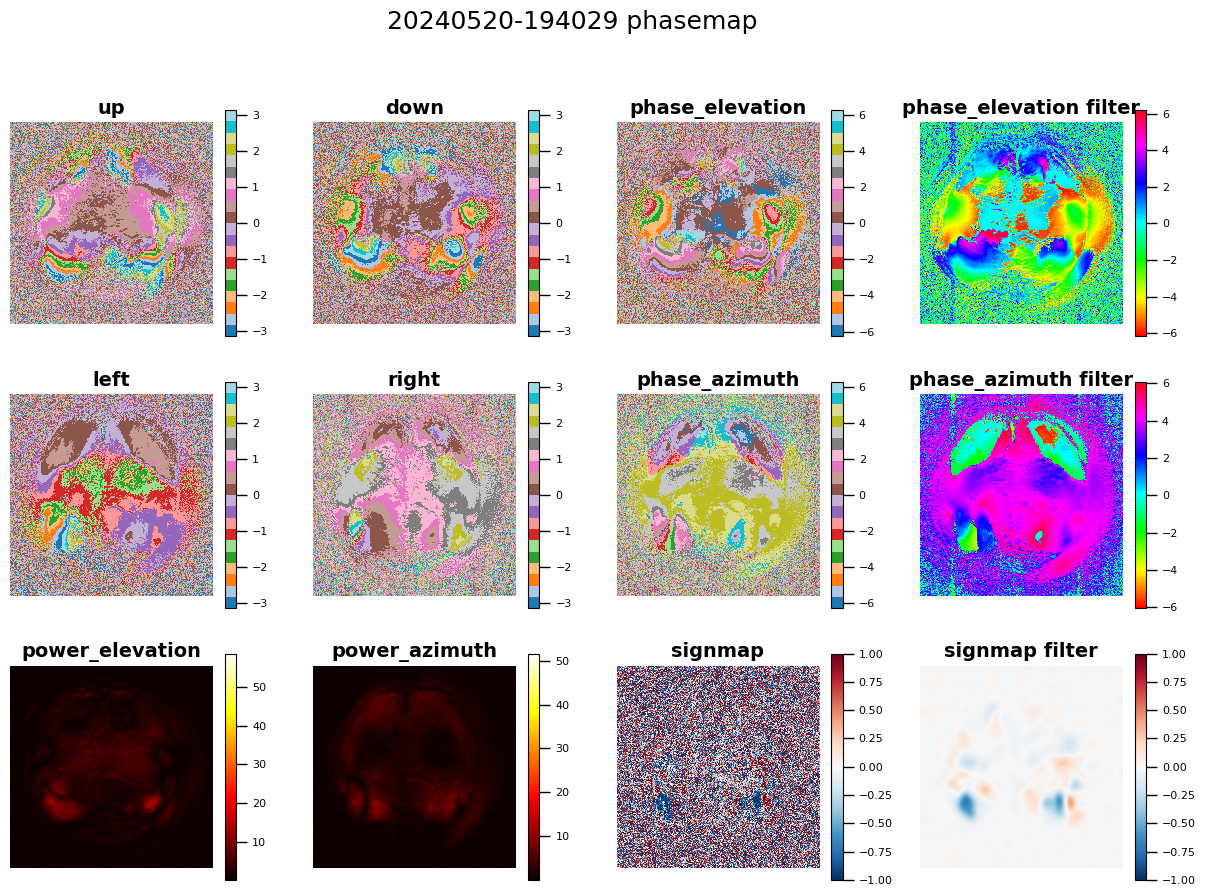

In [11]:
def visualSignMap(phasemap1, phasemap2):
    """
    calculate visual sign map from two orthogonally oriented phase maps
    """

    if phasemap1.shape != phasemap2.shape:
        raise LookupError("'phasemap1' and 'phasemap2' should have same size.")

    gradmap1 = np.gradient(phasemap1)
    gradmap2 = np.gradient(phasemap2)
    # gradmap1 = filters.median_filter(gradmap1,100.)
    # gradmap2 = filters.median_filter(gradmap2,100.)

    graddir1 = np.zeros(np.shape(gradmap1[0]))
    graddir2 = np.zeros(np.shape(gradmap2[0]))
    # gradmag1 = np.zeros(np.shape(gradmap1[0]))
    # gradmag2 = np.zeros(np.shape(gradmap2[0]))

    for i in range(phasemap1.shape[0]):
        for j in range(phasemap2.shape[1]):
            graddir1[i, j] = math.atan2(gradmap1[1][i, j], gradmap1[0][i, j])
            graddir2[i, j] = math.atan2(gradmap2[1][i, j], gradmap2[0][i, j])
            # gradmag1[i,j] = np.sqrt((gradmap1[1][i,j]**2)+(gradmap1[0][i,j]**2))
            # gradmag2[i,j] = np.sqrt((gradmap2[1][i,j]**2)+(gradmap2[0][i,j]**2))

    vdiff = np.multiply(np.exp(1j * graddir1), np.exp(-1j * graddir2))
    areamap = np.sin(np.angle(vdiff))

    return areamap


phase_az_filt = gaussian_filter(phase_az,0.5)
phase_el_filt = gaussian_filter(phase_el,0.5)
mag_el_filt = median_filter(mag_el,3)
mag_az_filt = median_filter(mag_az,3)
signmap = visualSignMap(phase_el_filt, phase_az_filt)
signmap_filt = gaussian_filter(signmap,10)


fig = plt.figure(figsize=[15, 10])
fig.add_subplot(3, 4, 1)
plt.imshow(cp.asnumpy(np.angle(up)),cmap='tab20')
plt.title('up')
plt.axis('off')
plt.colorbar()
fig.add_subplot(3, 4, 2)
plt.imshow(cp.asnumpy(np.angle(down)),cmap='tab20')
plt.title('down')
plt.colorbar()
plt.axis('off')
fig.add_subplot(3, 4, 3)
plt.imshow(phase_el,cmap='tab20')
plt.title('phase_elevation')
plt.axis('off')
plt.colorbar()
fig.add_subplot(3, 4, 4)
plt.imshow(phase_el_filt,cmap='hsv', interpolation='nearest')
plt.title('phase_elevation filter')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 4, 5)
plt.imshow(cp.asnumpy(np.angle(left)),cmap='tab20')
plt.title('left')
plt.axis('off')
plt.colorbar()
fig.add_subplot(3, 4, 6)
plt.imshow(cp.asnumpy(np.angle(right)),cmap='tab20')
plt.title('right')
plt.colorbar()
plt.axis('off')
fig.add_subplot(3, 4, 7)
plt.imshow(phase_az,cmap='tab20')
plt.title('phase_azimuth')
plt.axis('off')
plt.colorbar()
fig.add_subplot(3, 4, 8)
plt.imshow(phase_az_filt,cmap='hsv', interpolation='nearest')
plt.title('phase_azimuth filter')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 4, 9)
plt.imshow(mag_el_filt, cmap='hot', interpolation='nearest')
plt.title('power_elevation')
plt.axis('off')
plt.colorbar()
fig.add_subplot(3, 4, 10)
plt.imshow(mag_az_filt, cmap='hot', interpolation='nearest')
plt.title('power_azimuth')
plt.axis('off')
plt.colorbar()


fig.add_subplot(3, 4, 11)
plt.imshow(signmap, vmin=-1, vmax=1, cmap='RdBu_r', interpolation='nearest')
plt.title('signmap')
plt.axis('off')
plt.colorbar()
fig.add_subplot(3, 4, 12)
plt.imshow(signmap_filt, vmin=-1, vmax=1, cmap='RdBu_r', interpolation='nearest')
plt.title('signmap filter')
plt.axis('off')
plt.colorbar()

fig.set_facecolor('white')
plt.suptitle(os.path.basename(path_wfield)[:15] + ' phasemap', fontsize=18)
# plt.savefig(pjoin(path_out, 'all_map.png'), bbox_inches='tight')
plt.show()





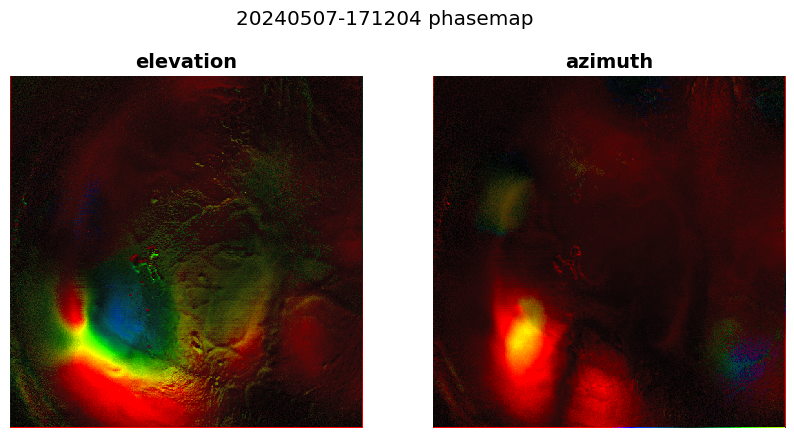

In [34]:
### plot phase maps

fig = plt.figure(figsize=[10, 5])
fig.add_subplot(1, 2, 1)
plt.imshow(im_fftphase_hsv([mag_el, phase_el], return_hsv=False))
plt.axis('off')
plt.title('elevation')
fig.add_subplot(1, 2, 2)
plt.imshow(im_fftphase_hsv([mag_az, phase_az], return_hsv=False))
plt.axis('off')
plt.title('azimuth')
fig.set_facecolor('white')
plt.suptitle(os.path.basename(path_wfield)[:15] + ' phasemap')
plt.savefig(pjoin(path_out, '1phasemap_unfiltered.png'), bbox_inches='tight')


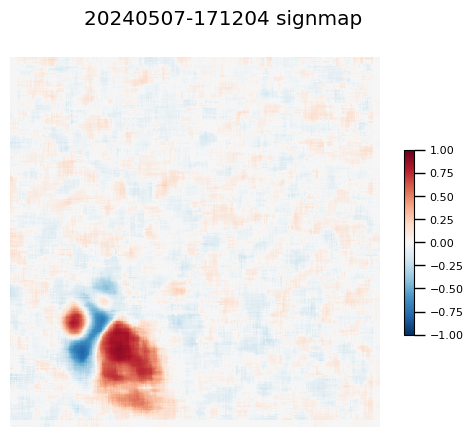

In [35]:
### plot sign maps

from scipy.ndimage import median_filter
fig = plt.figure()
plt.imshow(median_filter(visual_sign_map(phase_az, phase_el), 20),
           cmap='RdBu_r', clim=[-1, 1])
plt.colorbar(shrink=0.5)
plt.axis('off')
fig.set_facecolor('white')
plt.suptitle(os.path.basename(path_wfield)[:15] + ' signmap')
plt.savefig(pjoin(path_out, '1signmap.png'))


In [36]:
### export phase and magnitude

np.save(pjoin(path_out, '1phase_el.npy'), phase_el)
np.save(pjoin(path_out, '1phase_az.npy'), phase_az)
# np.save(pjoin(path_out, 'mag_el.npy'), mag_el)
# np.save(pjoin(path_out, 'mag_az.npy'), mag_az)
